In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from datetime import datetime
import pickle, json, sys, os, glob
import pandas as pd
from scipy.optimize import minimize
from scipy import optimize

pd.set_option("display.max_columns", None)

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from scipy.optimize import minimize
from scipy.stats import expon, powerlaw

# location of the scripts
sys.path.insert(0, os.path.join("/fefs/aswg/workspace/juan.jimenez/cosmic_ray_data_correction/scripts"))
import auxiliar as aux
import geometry as geom

# Configuration and paths

In [2]:
source_name = "crab"

# Root path of this script
root = "/fefs/aswg/workspace/juan.jimenez/cosmic_ray_data_correction/analysis_scaling_correlations/"
# Data main directory
root_data = root + f"../../data/cosmic_ray_data_correction/{source_name}/"
dir_objects = "/fefs/aswg/workspace/juan.jimenez/cosmic_ray_data_correction/analysis_weather/objects"

# directories for the data
dir_dl1b = root_data + "dl1b/"
dir_dl2  = root_data + "dl2/"

# Read dl2 data for all subruns available

In [3]:
run_dirs = [name for name in os.listdir(dir_dl2) if os.path.isdir(os.path.join(dir_dl2, name))]

DICTS = []

for rundir in run_dirs:
    
    print(f"Extracting for: {rundir}")
    
    dir_dl2_run = dir_dl2 + rundir
    
    files = glob.glob(dir_dl2_run + "/*")
    
    sruns = np.unique([int(f.split(".")[-3][:-3]) for f in files])
    
    for srun in sruns:
        dir_dl2_srun = dir_dl2_run + f"/*.{srun:04}_*"
        files_srun = glob.glob(dir_dl2_srun)
        
        _dict = {
            "run" : int(rundir),
            "srun" : srun, 
            "scale" : {},
        }
        
        for f in files_srun:
            
            scale = float(f.split("_s")[-1].split(".h5")[0])
            
            _dict["scale"][scale] = pd.read_hdf(f, key="dl2/event/telescope/parameters/LST_LSTCam")
            
        DICTS.append(_dict)

Extracting for: 01794
Extracting for: 02450
Extracting for: 01971
Extracting for: 01878
Extracting for: 01997
Extracting for: 01840
Extracting for: 01620
Extracting for: 02115
Extracting for: 01924
Extracting for: 02181
Extracting for: 02031
Extracting for: 01798
Extracting for: 02114
Extracting for: 01893
Extracting for: 03281
Extracting for: 01881
Extracting for: 01619
Extracting for: 01879
Extracting for: 01615
Extracting for: 01627
Extracting for: 06172
Extracting for: 04015
Extracting for: 12231
Extracting for: 01701
Extracting for: 01652
Extracting for: 01617
Extracting for: 04028
Extracting for: 01788
Extracting for: 01618
Extracting for: 02116
Extracting for: 01792
Extracting for: 01799
Extracting for: 01629
Extracting for: 01621
Extracting for: 01787
Extracting for: 01921
Extracting for: 02002
Extracting for: 01892
Extracting for: 01876
Extracting for: 01800
Extracting for: 01626
Extracting for: 04724
Extracting for: 01700
Extracting for: 01987
Extracting for: 02113
Extracting

# Read datacheck data

In [4]:
with open(dir_objects + "/data_dict.pkl", 'rb') as f:
    dict_dcheck = pickle.load(f)  

runs_list, sruns_list = [], []
for DICT in DICTS:
    _run  = DICT["run"]
    _srun = DICT["srun"]
    
#     print(f"Extracting for run {_run}")
    
    runs_list.append(_run)
    sruns_list.append(_srun)
    
    mask_run  = (dict_dcheck["run"] == _run)
    mask_srun = (dict_dcheck["srun"] == _srun)
    
    index = list(mask_run).index(True) + _srun # list(mask_run & mask_srun).index(True)
    
    dcheck_info = {}
    for key in dict_dcheck.keys():
        
        dcheck_info[key] = dict_dcheck[key][index]
    
    DICT["dcheck"] = dcheck_info

# ZD corrections

In [5]:
def pol2(x, a, b, c):
    return a + b * x + c * x * x

p0a = -0.44751321
p0b = 3.62502037
p0c = -1.43611437

p1a = -2.89253919
p1b = 0.99443581
p1c = -0.34013068

par0_at_zenith = pol2(1, p0a, p0b, p0c)
par1_at_zenith = pol2(1, p1a, p1b, p1c)

# All datacheck information extraction and mean values

Mode of rate @ 422 p.e. : 1.68
Mean of power law index: -2.23


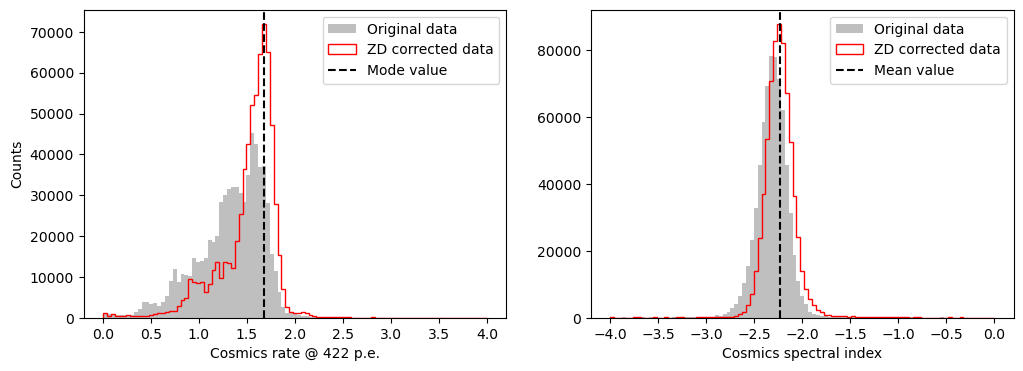

In [6]:
# Plot the distributions we are interested in 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(dict_dcheck["cosmics_rate_at_422_pe"], histtype="stepfilled", color="gray", alpha=0.5, bins=np.linspace(0, 4, 100), label="Original data")
ax1.hist(dict_dcheck["ZD_corrected_cosmics_rate_at_422_pe"], histtype="step", color="r", bins=np.linspace(0, 4, 100), label="ZD corrected data")
ax2.hist(dict_dcheck["cosmics_spectral_index"], histtype="stepfilled", color="gray", alpha=0.5, label="Original data", bins=np.linspace(-4, 0, 100))
ax2.hist(dict_dcheck["ZD_corrected_cosmics_spectral_index"],histtype="step", color="r", bins=np.linspace(-4, 0, 100), label="ZD corrected data")

_counts, _bin_edges = np.histogram(dict_dcheck["ZD_corrected_cosmics_rate_at_422_pe"], bins=np.linspace(0, 4, 100))

maxindex = np.argmax(_counts)
mode_rates = np.mean([_bin_edges[maxindex], _bin_edges[maxindex+1]])
mean_index = np.nanmean(dict_dcheck["ZD_corrected_cosmics_spectral_index"])

ax1.axvline(mode_rates, color="k", ls="--", label="Mode value")
ax2.axvline(mean_index, color="k", ls="--", label="Mean value")

print("Mode of rate @ 422 p.e. : {:.2f}\nMean of power law index: {:.2f}".format(mode_rates, mean_index))

ax1.set_ylabel("Counts")
ax1.set_xlabel("Cosmics rate @ 422 p.e.")
ax2.set_xlabel("Cosmics spectral index")
for ax in [ax1, ax2]:
    ax.legend()
plt.show()

In [7]:
limsint = [316, 562]

bins = np.linspace(2 * 10**1, 1700, 400)
bins_c    = bins[:-1] / 2 + bins[1:] / 2
bins_size = np.diff(bins)
mask_bins = []
for b in bins_c:
    if b >= limsint[0] and b <= limsint[1]:
        mask_bins.append(True)
    else:
        mask_bins.append(False)

0/265: Analysing run 1794 subrun 13


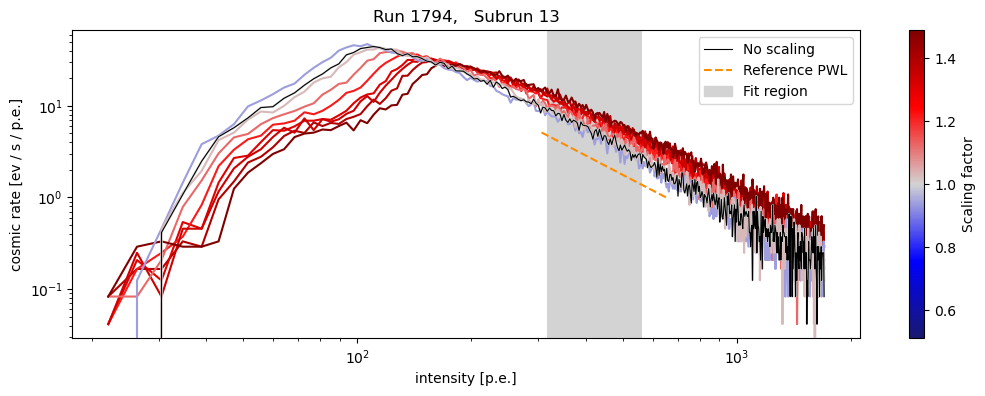

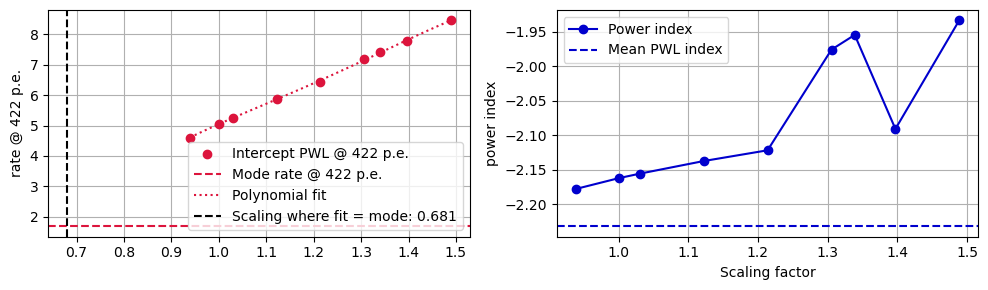

1/265: Analysing run 1971 subrun 4
2/265: Analysing run 1878 subrun 45
3/265: Analysing run 1878 subrun 50
4/265: Analysing run 1878 subrun 63
5/265: Analysing run 1997 subrun 35
6/265: Analysing run 1840 subrun 29
7/265: Analysing run 1840 subrun 44
8/265: Analysing run 1620 subrun 0
9/265: Analysing run 1620 subrun 1
10/265: Analysing run 1620 subrun 2
11/265: Analysing run 1620 subrun 3
12/265: Analysing run 1620 subrun 4
13/265: Analysing run 1620 subrun 5
14/265: Analysing run 1620 subrun 6
15/265: Analysing run 1620 subrun 46


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


16/265: Analysing run 1620 subrun 47


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))
/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


17/265: Analysing run 2115 subrun 9
18/265: Analysing run 2115 subrun 10


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))
/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


19/265: Analysing run 2115 subrun 120
20/265: Analysing run 2115 subrun 121


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


21/265: Analysing run 1924 subrun 9
22/265: Analysing run 2031 subrun 113
23/265: Analysing run 1798 subrun 18
24/265: Analysing run 1798 subrun 19
25/265: Analysing run 1798 subrun 25
26/265: Analysing run 1798 subrun 28
27/265: Analysing run 2114 subrun 64


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


28/265: Analysing run 2114 subrun 65


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


29/265: Analysing run 2114 subrun 72
30/265: Analysing run 2114 subrun 73


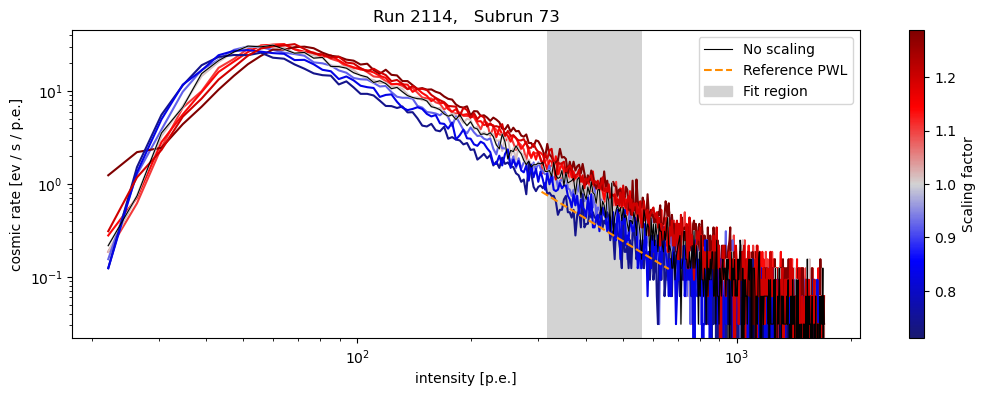

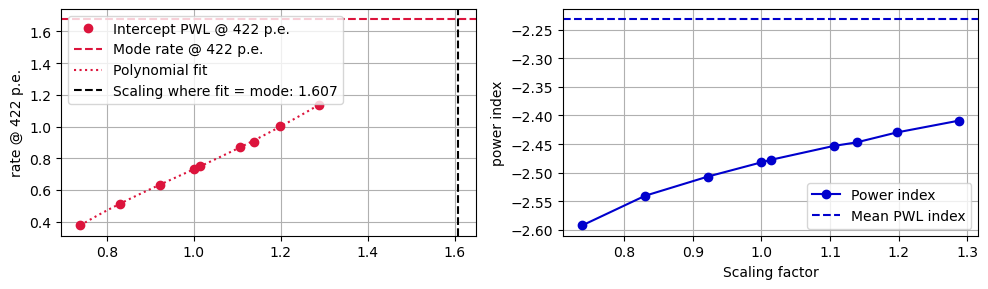

31/265: Analysing run 2114 subrun 74
32/265: Analysing run 2114 subrun 75
33/265: Analysing run 2114 subrun 76
34/265: Analysing run 2114 subrun 77
35/265: Analysing run 2114 subrun 78
36/265: Analysing run 1893 subrun 32


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


37/265: Analysing run 1893 subrun 33


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))
/fefs/aswg/workspace/juan.jimenez/cosmic_ray_data_correction/scripts/auxiliar.py:211: RuntimeWarning: invalid value encountered in scalar divide
  normalized_value = (array[i] - m) / (M - m)


38/265: Analysing run 3281 subrun 0
39/265: Analysing run 1881 subrun 138
40/265: Analysing run 1881 subrun 165
41/265: Analysing run 1619 subrun 0
42/265: Analysing run 1619 subrun 1
43/265: Analysing run 1619 subrun 2
44/265: Analysing run 1619 subrun 3
45/265: Analysing run 1619 subrun 4
46/265: Analysing run 1619 subrun 5
47/265: Analysing run 1619 subrun 6
48/265: Analysing run 1619 subrun 11


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))
/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


49/265: Analysing run 1619 subrun 12
50/265: Analysing run 1879 subrun 34
51/265: Analysing run 1879 subrun 35
52/265: Analysing run 1615 subrun 0
53/265: Analysing run 1615 subrun 1
54/265: Analysing run 1615 subrun 2
55/265: Analysing run 1615 subrun 3
56/265: Analysing run 1615 subrun 4
57/265: Analysing run 1615 subrun 5
58/265: Analysing run 1615 subrun 6
59/265: Analysing run 1615 subrun 7


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


60/265: Analysing run 1615 subrun 8


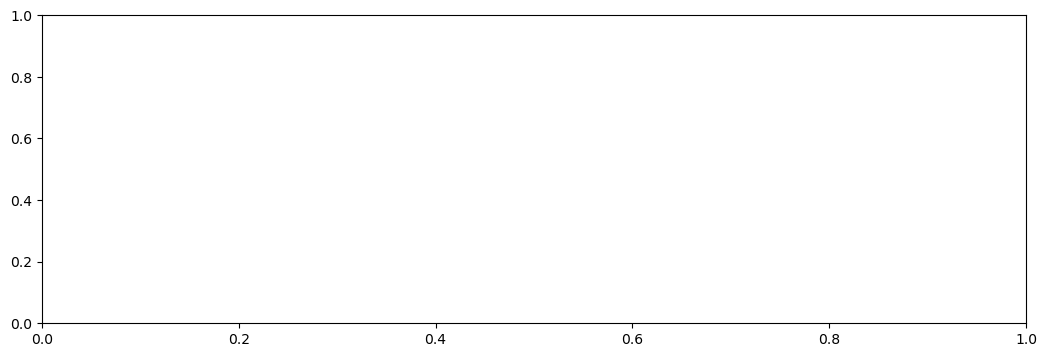

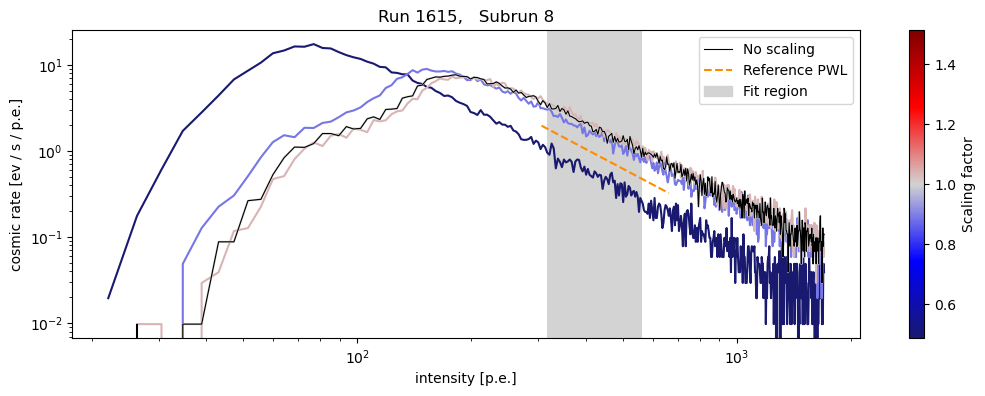

/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


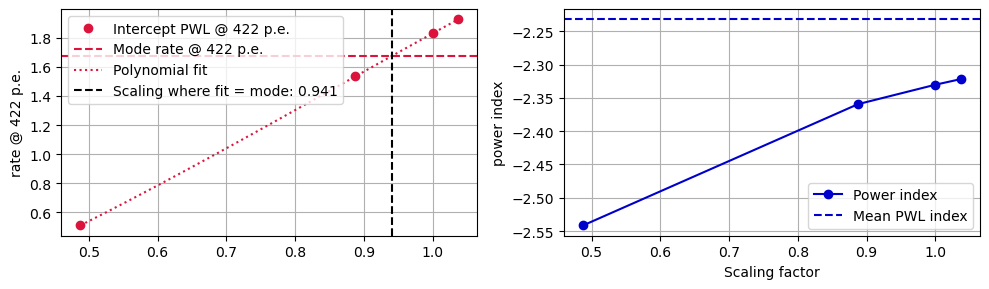

61/265: Analysing run 1615 subrun 23
62/265: Analysing run 1615 subrun 24
63/265: Analysing run 1615 subrun 25
64/265: Analysing run 1615 subrun 26
65/265: Analysing run 1615 subrun 27
66/265: Analysing run 1615 subrun 28
67/265: Analysing run 1615 subrun 29
68/265: Analysing run 1615 subrun 31


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


69/265: Analysing run 1615 subrun 32


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


70/265: Analysing run 1615 subrun 54


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


71/265: Analysing run 1615 subrun 55


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


72/265: Analysing run 1627 subrun 0
73/265: Analysing run 1627 subrun 1
74/265: Analysing run 1627 subrun 2
75/265: Analysing run 1627 subrun 3
76/265: Analysing run 1627 subrun 4
77/265: Analysing run 1627 subrun 16


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


78/265: Analysing run 1627 subrun 17


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


79/265: Analysing run 1627 subrun 38
80/265: Analysing run 1627 subrun 50
81/265: Analysing run 6172 subrun 0
82/265: Analysing run 6172 subrun 1
83/265: Analysing run 6172 subrun 2
84/265: Analysing run 6172 subrun 3
85/265: Analysing run 6172 subrun 4
86/265: Analysing run 6172 subrun 5
87/265: Analysing run 6172 subrun 7
88/265: Analysing run 6172 subrun 8
89/265: Analysing run 6172 subrun 10
90/265: Analysing run 6172 subrun 11


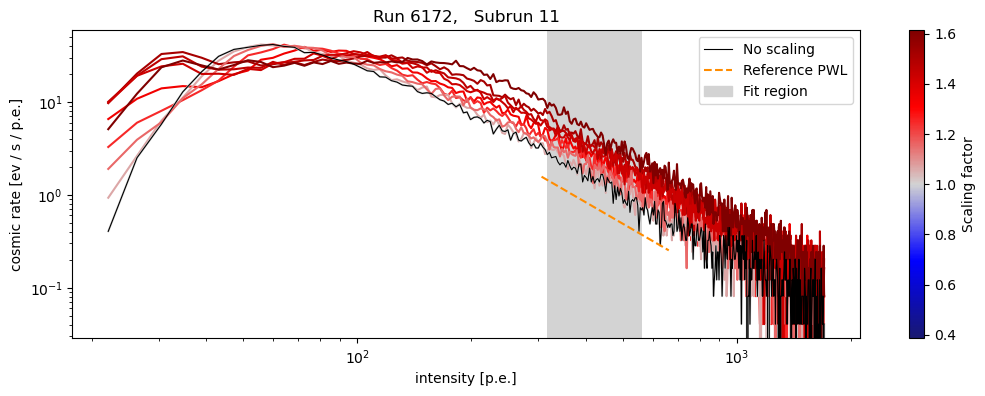

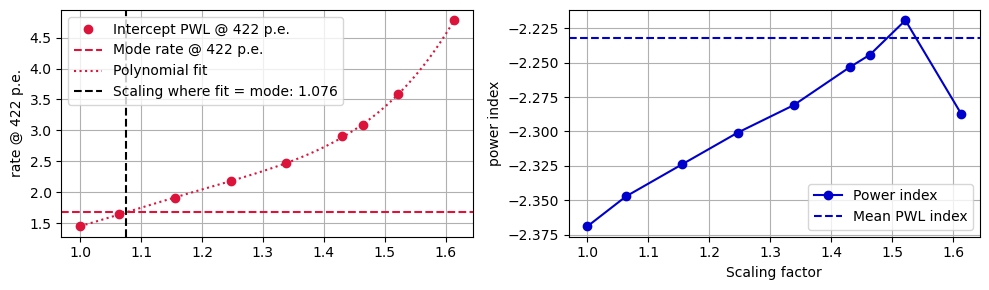

91/265: Analysing run 6172 subrun 13
92/265: Analysing run 6172 subrun 15
93/265: Analysing run 6172 subrun 16
94/265: Analysing run 6172 subrun 18
95/265: Analysing run 6172 subrun 19
96/265: Analysing run 6172 subrun 21
97/265: Analysing run 6172 subrun 22
98/265: Analysing run 6172 subrun 29
99/265: Analysing run 6172 subrun 37
100/265: Analysing run 6172 subrun 44
101/265: Analysing run 6172 subrun 51
102/265: Analysing run 6172 subrun 57
103/265: Analysing run 6172 subrun 70
104/265: Analysing run 6172 subrun 75
105/265: Analysing run 6172 subrun 98
106/265: Analysing run 4015 subrun 17
107/265: Analysing run 4015 subrun 18
108/265: Analysing run 4015 subrun 19
109/265: Analysing run 4015 subrun 20
110/265: Analysing run 4015 subrun 21
111/265: Analysing run 4015 subrun 22
112/265: Analysing run 12231 subrun 13
113/265: Analysing run 12231 subrun 14


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))
/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


114/265: Analysing run 1701 subrun 6
115/265: Analysing run 1701 subrun 7
116/265: Analysing run 1652 subrun 16
117/265: Analysing run 1652 subrun 17
118/265: Analysing run 1617 subrun 0
119/265: Analysing run 1617 subrun 1
120/265: Analysing run 1617 subrun 2


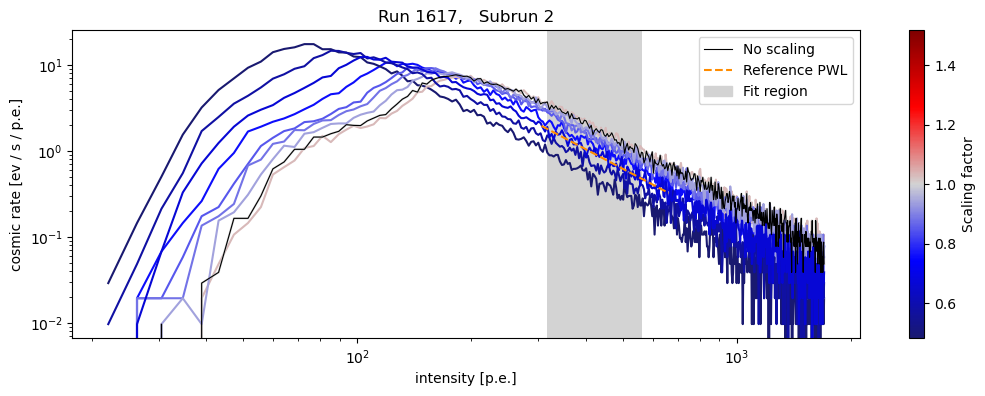

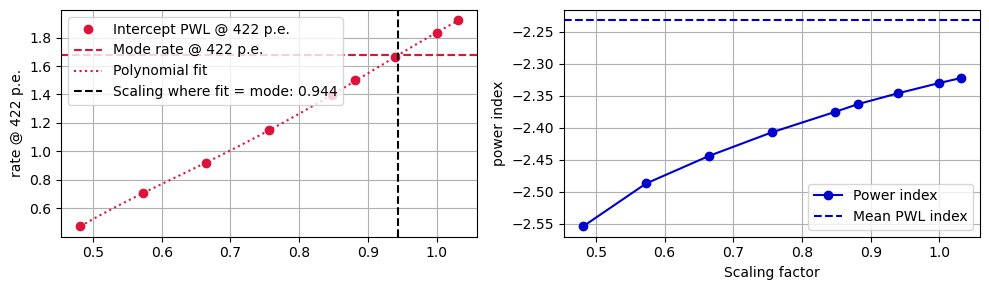

121/265: Analysing run 1617 subrun 3
122/265: Analysing run 1617 subrun 4
123/265: Analysing run 1617 subrun 5
124/265: Analysing run 1617 subrun 6
125/265: Analysing run 1617 subrun 7
126/265: Analysing run 1617 subrun 8
127/265: Analysing run 1617 subrun 15


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


128/265: Analysing run 1617 subrun 16


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


129/265: Analysing run 4028 subrun 0
130/265: Analysing run 4028 subrun 1
131/265: Analysing run 4028 subrun 2
132/265: Analysing run 4028 subrun 3
133/265: Analysing run 4028 subrun 4
134/265: Analysing run 4028 subrun 5
135/265: Analysing run 4028 subrun 9
136/265: Analysing run 4028 subrun 10
137/265: Analysing run 4028 subrun 13
138/265: Analysing run 4028 subrun 14
139/265: Analysing run 4028 subrun 20
140/265: Analysing run 4028 subrun 21
141/265: Analysing run 4028 subrun 27
142/265: Analysing run 4028 subrun 28
143/265: Analysing run 4028 subrun 30
144/265: Analysing run 4028 subrun 31
145/265: Analysing run 4028 subrun 41
146/265: Analysing run 4028 subrun 43
147/265: Analysing run 4028 subrun 44
148/265: Analysing run 4028 subrun 49
149/265: Analysing run 1788 subrun 57
150/265: Analysing run 1788 subrun 59


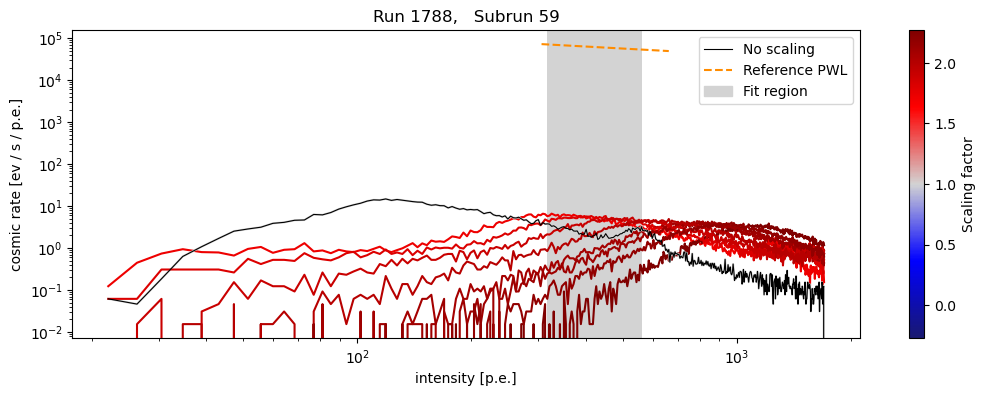

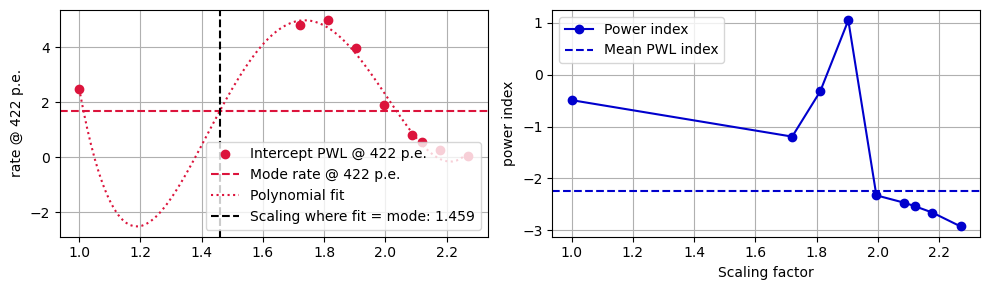

151/265: Analysing run 1788 subrun 60
152/265: Analysing run 1788 subrun 61
153/265: Analysing run 1788 subrun 62
154/265: Analysing run 1788 subrun 63
155/265: Analysing run 1788 subrun 64
156/265: Analysing run 1618 subrun 0
157/265: Analysing run 1618 subrun 1
158/265: Analysing run 1618 subrun 2
159/265: Analysing run 1618 subrun 3
160/265: Analysing run 1618 subrun 4
161/265: Analysing run 1618 subrun 5
162/265: Analysing run 1618 subrun 6
163/265: Analysing run 1618 subrun 8


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


164/265: Analysing run 1618 subrun 36
165/265: Analysing run 1618 subrun 37
166/265: Analysing run 1618 subrun 38
167/265: Analysing run 1618 subrun 39
168/265: Analysing run 1618 subrun 40
169/265: Analysing run 1618 subrun 41
170/265: Analysing run 1618 subrun 42
171/265: Analysing run 1618 subrun 62


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


172/265: Analysing run 1618 subrun 63


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


173/265: Analysing run 1618 subrun 70
174/265: Analysing run 1618 subrun 71
175/265: Analysing run 1618 subrun 74
176/265: Analysing run 2116 subrun 88
177/265: Analysing run 2116 subrun 89
178/265: Analysing run 2116 subrun 90
179/265: Analysing run 2116 subrun 91
180/265: Analysing run 2116 subrun 92


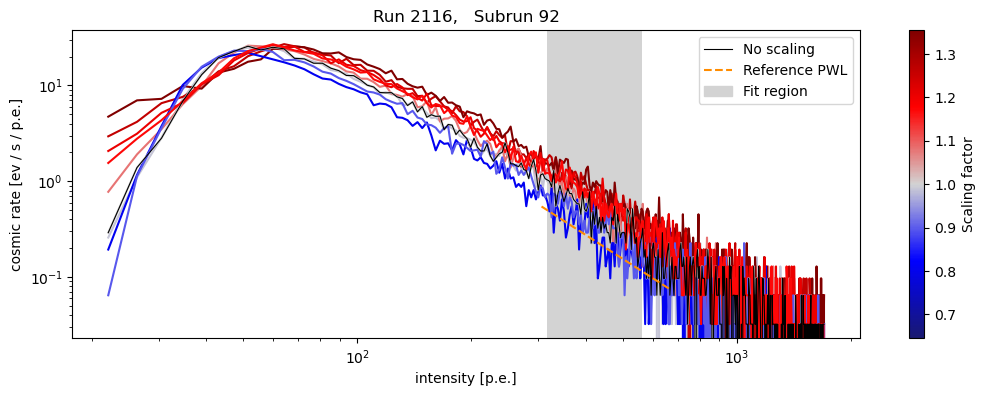

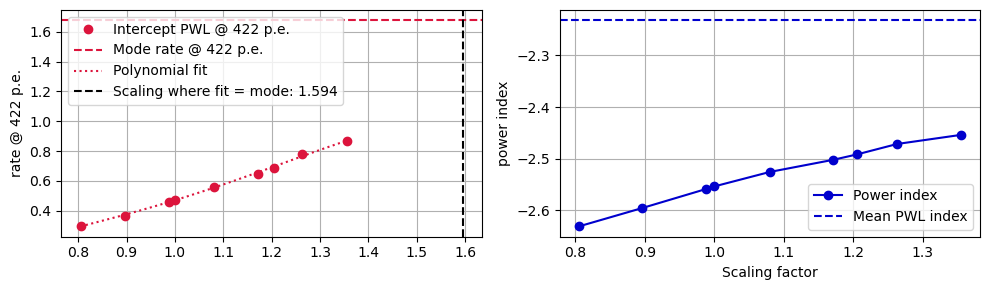

181/265: Analysing run 2116 subrun 93
182/265: Analysing run 2116 subrun 94
183/265: Analysing run 2116 subrun 96


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


184/265: Analysing run 2116 subrun 97


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


185/265: Analysing run 1792 subrun 2
186/265: Analysing run 1792 subrun 26
187/265: Analysing run 1792 subrun 36
188/265: Analysing run 1792 subrun 43
189/265: Analysing run 1799 subrun 220
190/265: Analysing run 1799 subrun 232
191/265: Analysing run 1799 subrun 235
192/265: Analysing run 1799 subrun 240
193/265: Analysing run 1799 subrun 247
194/265: Analysing run 1799 subrun 255
195/265: Analysing run 1799 subrun 259
196/265: Analysing run 1799 subrun 261
197/265: Analysing run 1799 subrun 262
198/265: Analysing run 1629 subrun 3


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))
/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


199/265: Analysing run 1629 subrun 4
200/265: Analysing run 1629 subrun 26


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))
/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


201/265: Analysing run 1629 subrun 27
202/265: Analysing run 1621 subrun 0
203/265: Analysing run 1621 subrun 19
204/265: Analysing run 1621 subrun 32


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


205/265: Analysing run 1621 subrun 33


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


206/265: Analysing run 1787 subrun 138
207/265: Analysing run 1921 subrun 42
208/265: Analysing run 1921 subrun 43
209/265: Analysing run 1921 subrun 44
210/265: Analysing run 1921 subrun 81


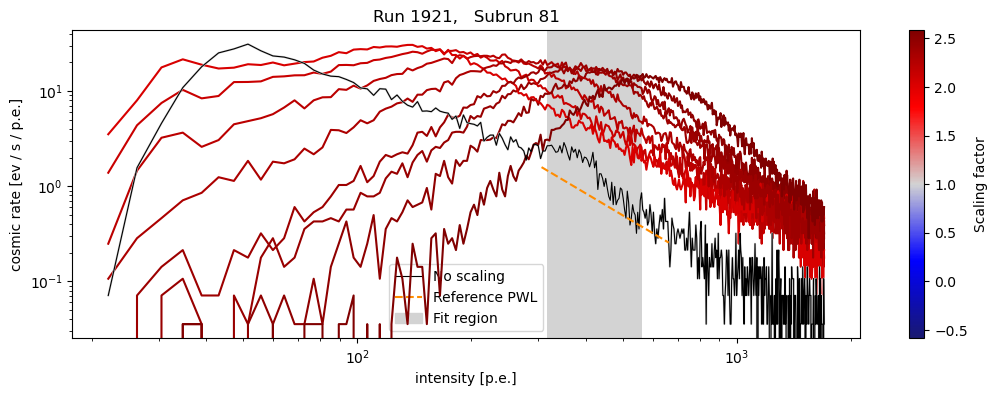

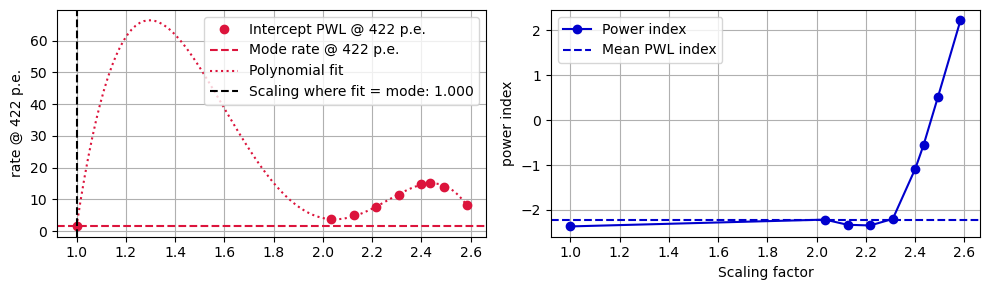

211/265: Analysing run 1921 subrun 82
212/265: Analysing run 1921 subrun 86
213/265: Analysing run 1921 subrun 91
214/265: Analysing run 1921 subrun 245
215/265: Analysing run 1921 subrun 259
216/265: Analysing run 1921 subrun 277
217/265: Analysing run 1892 subrun 6


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


218/265: Analysing run 1892 subrun 7


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


219/265: Analysing run 1892 subrun 16
220/265: Analysing run 1892 subrun 17
221/265: Analysing run 1892 subrun 18
222/265: Analysing run 1892 subrun 19
223/265: Analysing run 1892 subrun 20
224/265: Analysing run 1892 subrun 21
225/265: Analysing run 1892 subrun 22
226/265: Analysing run 1892 subrun 36
227/265: Analysing run 1892 subrun 37


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))
/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


228/265: Analysing run 1876 subrun 146
229/265: Analysing run 1800 subrun 56
230/265: Analysing run 1800 subrun 57


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))
/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


231/265: Analysing run 1626 subrun 0
232/265: Analysing run 1626 subrun 1
233/265: Analysing run 1626 subrun 3
234/265: Analysing run 1626 subrun 4
235/265: Analysing run 4724 subrun 44
236/265: Analysing run 4724 subrun 45


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))
/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


237/265: Analysing run 1700 subrun 15
238/265: Analysing run 1987 subrun 62
239/265: Analysing run 1987 subrun 63
240/265: Analysing run 1987 subrun 65


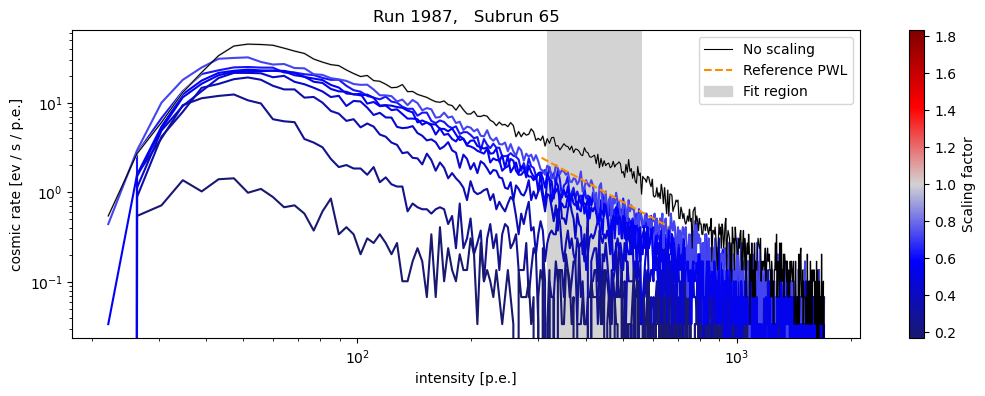

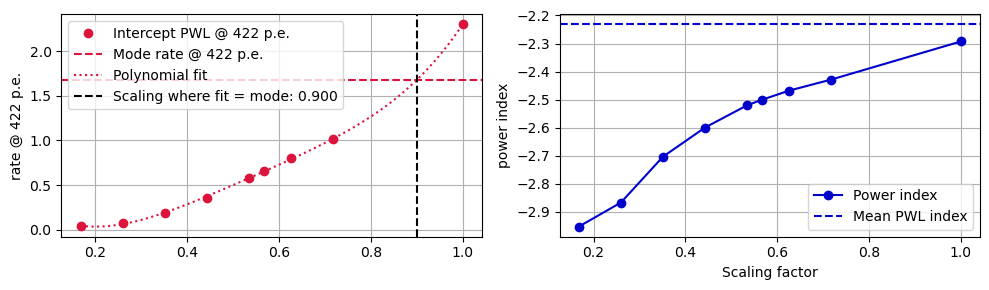

241/265: Analysing run 1987 subrun 66
242/265: Analysing run 2113 subrun 113


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))
/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


243/265: Analysing run 2113 subrun 114
244/265: Analysing run 2117 subrun 17


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))
/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


245/265: Analysing run 2117 subrun 18
246/265: Analysing run 2117 subrun 136


/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))
/tmp/ipykernel_488/969632296.py:92: RankWarning: Polyfit may be poorly conditioned
  pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))


247/265: Analysing run 2117 subrun 137
248/265: Analysing run 1998 subrun 53
249/265: Analysing run 1998 subrun 65
250/265: Analysing run 3954 subrun 0
251/265: Analysing run 3954 subrun 1
252/265: Analysing run 3954 subrun 2
253/265: Analysing run 3954 subrun 3
254/265: Analysing run 3954 subrun 4
255/265: Analysing run 3954 subrun 5
256/265: Analysing run 3954 subrun 7
257/265: Analysing run 3954 subrun 8
258/265: Analysing run 3954 subrun 40
259/265: Analysing run 3954 subrun 57
260/265: Analysing run 3954 subrun 80
261/265: Analysing run 3954 subrun 81
262/265: Analysing run 3954 subrun 83
263/265: Analysing run 3954 subrun 93
264/265: Analysing run 3954 subrun 100


In [10]:
# Arrays to store the calculated fit parameters of the power laws
scaling_needed = [] 
rates_422_pe   = []
p_law_indexes  = []
zd_corr_rates_422_pe   = []
zd_corr_p_law_indexes  = []
zeniths        = []

# Now we iterate over all the RunSrun cases
for iii, DICT in enumerate(DICTS[:]):

    try:
        print("{}/{}: Analysing run {} subrun {}".format(iii, len(DICTS), DICT["run"], DICT["srun"]))

        # Repeating for each scaling factor-------------------------------------
        # The output objects we want to obtain from the analysis
        plaw_amplitud_srun = []
        plaw_indexes_srun  = []
        rate_422_pe_srun   = []
        scale_srun         = []
        rates_srun         = []
        for scale in DICT["scale"].keys():

            # Binning the data in a histogram in natural scale ---------------------
            counts, _ = np.histogram(DICT["scale"][scale]["intensity"], bins=bins)
            rates     = counts / DICT["dcheck"]["telapsed"] / bins_size

            # Fitting the data to a power law --------------------------------------
            initial_params = [2.4e6, -1] # Approximate first try
            result = minimize(geom.likelihood_plaw, x0=initial_params, args=(bins_c[mask_bins], rates[mask_bins]))
            amplitud, p_index = result.x    

            plaw_amplitud_srun.append(amplitud)
            plaw_indexes_srun.append(p_index)
            rate_422_pe_srun.append(geom.plaw(422, amplitud, p_index))
            scale_srun.append(scale)
            rates_srun.append(rates)



        ####################################
        # plotting the results
        ####################################
        fig = plt.figure(figsize=(12.7, 4))
        ax1 = fig.add_axes(111)
        
        # Color plot selection
        pcols = ["midnightblue", "b", "lightgray", "r", "maroon"]
        max_dev_from_1 = np.max(np.abs(np.array(scale_srun) - 1))
        colors = aux.get_colors_multiplot(scale_srun, COLORS=pcols, ran=[1-max_dev_from_1, 1+max_dev_from_1])
        cmap   = aux.create_cmap(pcols)
        aux.plot_colorbar(fig, ax1, [1-max_dev_from_1, 1+max_dev_from_1], cmap, label="Scaling factor")

        ax1.plot(bins_c, rates_srun[scale_srun.index(1)], color="k", lw=0.8, zorder=10, label="No scaling")

        for i, scale in enumerate(scale_srun):
            ax1.plot(bins_c, rates_srun[i], color=colors[i], zorder=i)

        bins_space = np.linspace(limsint[0]-10, limsint[1]+100, 100)
        AA = 10 ** (np.log10(mode_rates) - mean_index * np.log10(422))
        kk = plaw_indexes_srun[scale_srun.index(1)]
        ax1.plot(bins_space, geom.plaw(bins_space, AA, kk), zorder=100, ls="--", color="darkorange", label="Reference PWL")

        ax1.axvspan(limsint[0], limsint[1], zorder=-100, color="lightgray", ls="", label="Fit region")
        ax1.legend()
        ax1.set_xlabel("intensity [p.e.]")

        # Plot settings
        ax1.set_ylabel("cosmic rate [ev / s / p.e.]") 
        ax1.loglog()
        ax1.set_title("Run {},   Subrun {}".format(DICT["run"], DICT["srun"]))
        
        if iii % 30 == 0:
            plt.show()
        else:
            plt.close()
        
        fig = plt.figure(figsize=(10, 3))

        ax  = fig.add_axes(122)
        axt = fig.add_axes(121)        
        
        
        p1, = ax.plot(*aux.sortbased(plaw_indexes_srun, scale_srun), color="mediumblue", marker="o", label="Power index")
        p2, = axt.plot(*aux.sortbased(rate_422_pe_srun, scale_srun), color="crimson", ls="", marker="o", label="Intercept PWL @ 422 p.e.")
         
        
        ax.axhline(mean_index,  color="mediumblue", ls="--", label=f"Mean PWL index")
        axt.axhline(mode_rates, color="crimson", ls="--", label=f"Mode rate @ 422 p.e.")

        xp = np.linspace(min(scale_srun), max(scale_srun), 100)
        pol = np.poly1d(np.polyfit(*aux.sortbased(rate_422_pe_srun, scale_srun), 4))
        axt.plot(xp, pol(xp), ':', color="crimson", label="Polynomial fit")

        sol = optimize.root(pol-mode_rates, x0=1.2, method='hybr')
        axt.axvline(sol.x, color="k", ls="--", label=f"Scaling where fit = mode: {sol.x[0]:.3f}")

        for axx in [ax, axt]:
            axx.legend()
            axx.grid()
        ax.set_ylabel("power index")
        axt.set_ylabel("rate @ 422 p.e.")
        ax.set_xlabel("Scaling factor")
        fig.tight_layout()
        
        if iii % 30 == 0:
            plt.show()
        else:
            plt.close()

        scaling_needed.append(sol.x[0])
        rates_422_pe.append(rate_422_pe_srun[scale_srun.index(1)])
        p_law_indexes.append(plaw_indexes_srun[scale_srun.index(1)])
        zeniths.append(DICT["dcheck"]["zd"])
        
        par0_correction = par0_at_zenith / pol2(np.cos(np.deg2rad(DICT["dcheck"]["zd"])), p0a, p0b, p0c)
        par1_correction = par1_at_zenith - pol2(np.cos(np.deg2rad(DICT["dcheck"]["zd"])), p1a, p1b, p1c)        
        
        zd_corr_rates_422_pe.append(rate_422_pe_srun[scale_srun.index(1)] * par0_correction)
        zd_corr_p_law_indexes.append(plaw_indexes_srun[scale_srun.index(1)] + par1_correction)
        
    except:
        pass

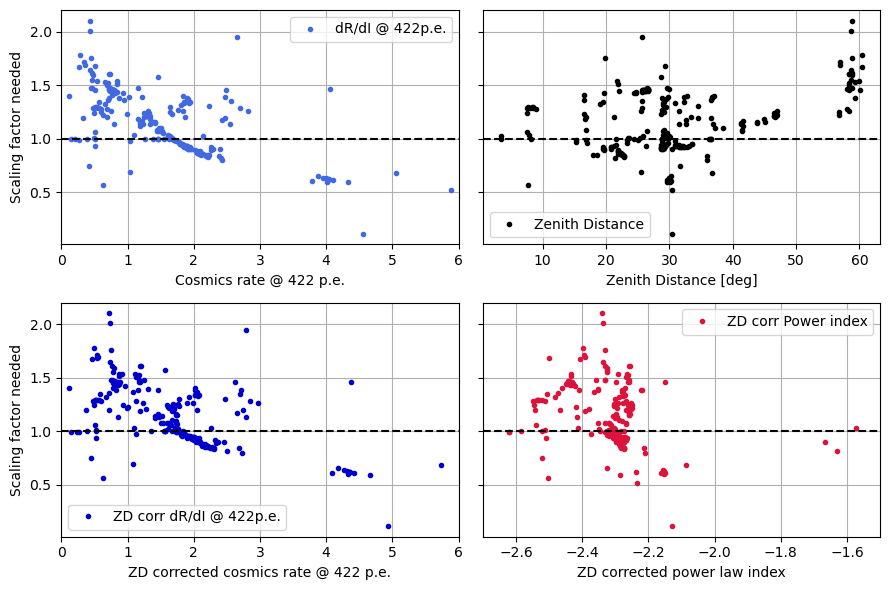

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 6), sharey=True)

ax1.plot(rates_422_pe,          scaling_needed, marker=".", color="royalblue",  label="dR/dI @ 422p.e.",         ls="")
ax2.plot(zeniths,               scaling_needed, marker=".", color="k",          label="Zenith Distance",         ls="")
ax3.plot(zd_corr_rates_422_pe,  scaling_needed, marker=".", color="mediumblue", label="ZD corr dR/dI @ 422p.e.", ls="")
ax4.plot(zd_corr_p_law_indexes, scaling_needed, marker=".", color="crimson",    label="ZD corr Power index",     ls="")

for ax in [ax1, ax2, ax3, ax4]:
    ax.axhline(1, color="k", ls="--")
    ax.grid()
    ax.legend()

ax1.set_ylabel("Scaling factor needed")
ax1.set_xlabel("Cosmics rate @ 422 p.e.")
ax2.set_xlabel("Zenith Distance [deg]")
ax3.set_ylabel("Scaling factor needed")
ax3.set_xlabel("ZD corrected cosmics rate @ 422 p.e.")
ax4.set_xlabel("ZD corrected power law index")

ax1.set_xlim(0, 6)
ax3.set_xlim(0, 6)
ax4.set_xlim(-2.7, -1.5)

fig.tight_layout()

plt.show()